In [1]:
# Author: Guoqing Bao
# School of Computer Science, The University of Sydney
# Date: 2019-12-12
# GitHub Project Link: https://github.com/guoqingbao/Pathofusion
# Please cite our work if you found it is useful for your research or clinical practice


import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = 10000000000
import cv2
import sqlite3
%matplotlib inline
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
import pandas as pd
import cv2
from urllib.request import urlopen
import io
import gc
gc.enable()
# import helper function (database manupulation, image augmentation, plot performance, train, etc.)
from project.models.helper import *
# import our BCNN from models
from project.models.bcnn import BCNN

Using TensorFlow backend.


# Prepare whole-slide images and model

In [2]:
GRADE = 4
PATIENT_ID = 11 # remember to change this when you prediction other whole-slide images

image_name = "CD276_P" + str(PATIENT_ID) # the  whole-slide image file name that we will predict
image_path = "http://xx.xx.xx.xx/static/labelling/" #it's path, we just uploaded them under the website static path
image_file = image_path + image_name + ".jpg"

urlsession = urlopen(image_file)
image_io = io.BytesIO(urlsession.read())  
img_origin = Image.open(image_io)
w = img_origin.width
h = img_origin.height

x = 512/2
y = 512/2

In [3]:
stride = 50

cols = int((w - 512)/stride) - int(256/stride)
rows = int((h - 512)/stride) - int(256/stride)

print("Width={}, height={}, start from (x={}, y={}), stride={}, total rows={}, total columns={})".format(w, h, x, y,stride, rows, cols))

Width=22415, height=19207, start from (x=256.0, y=256.0), stride=50, total rows=368, total columns=433)


In [4]:
project_path = './project/brain/'
path = project_path + "results/prediction_cd276/"
model_path = project_path + "results/bcnn/"

In [5]:
# load trained model
model = BCNN(2, False)
checkPoint = torch.load(model_path + 'torch_model_cd276.h5')
model.load_state_dict(checkPoint)
model = nn.DataParallel(model).cuda()
print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

Number of model parameters: 11617250


In [6]:
# to re-predict the whole-slide images, you may delete prediction_index files (under results/prediction_cd276), otherwise it will use the existed prediction results

total = rows * cols
progress = 0
prediction_array = None
intensity_array = []

start_row = 0

try:
    with open(path + 'prediction_index'+str(PATIENT_ID) + '.txt', 'r') as f:
        prediction_array = np.load(path + 'prediction_array' +str(PATIENT_ID) + '.npy')
        num = f.readline()
        f.close()
        start_row = int(num) + 1
        print("Row start from {}".format(start_row))
except OSError:
    print("file not found")

file not found


# Prediction of the whole-slide images (patch by patch approach)

In [2]:
model.eval()
# let's predict the whole-slide image patch by patch
# cropped from up-left to bottom-right
for row in range(start_row,rows):
    crop_images_256 = []
    crop_images_512 = []
#     print("Processing (row {})...".format(row))
    for col in range(cols):
        seq = row * cols + col
        xx1 = int(x + col * stride)
        yy1 = int(y + row * stride)
        # crop two resolution image patches
        img_256 = img_origin.crop((xx1,yy1,xx1 + 256,yy1 + 256)) # (left, upper, right, lower)-tuple.
        crop_images_256.append(np.asarray(img_256)/255)
        
        xx2, yy2 = int(xx1-128), int(yy1-128)
        img_512 = img_origin.crop((xx2,yy2,xx2 + 512,yy2 + 512)) # (left, upper, right, lower)-tuple.
        crop_images_512.append(np.asarray(img_512)/255)
        
        intensity_array.append((np.mean(img_256) + np.mean(img_512))/2)
        
        del img_256, img_512
        
    tests_array_256 = np.array(crop_images_256, dtype='float32')
    tests_array_512 = np.array(crop_images_512, dtype='float32')
    tests_array_256 = np.transpose(tests_array_256, (0, 3,1,2))
    tests_array_512 = np.transpose(tests_array_512, (0, 3,1,2))
    pred = []
    # predict one row at each iteration
    with torch.no_grad():
        for i in range(int(cols/100) + 1):
            a = tests_array_256[i*100:(i+1)*100]
            b = tests_array_512[i*100:(i+1)*100]
            m1, m2 = Variable(torch.FloatTensor(a).cuda()), Variable(torch.FloatTensor(b).cuda())
            yret = model(m1, m2)
            pred.extend(F.softmax(yret).cpu().numpy().tolist())
    ret = np.array(pred)


    if row == 0:
        prediction_array = ret
    else:
        prediction_array = np.vstack([prediction_array, ret])
        
    #save prediction    
    np.save(path + 'prediction_array'+str(PATIENT_ID) + '.npy',prediction_array)
    np.save(path + 'intensity_array'+str(PATIENT_ID) + '.npy',intensity_array)
    
    with open(path + 'prediction_index'+str(PATIENT_ID) + '.txt', 'w') as f:
        f.write('%d' % row)
        f.close()
        
    del tests_array_256
    del tests_array_512         
    del crop_images_256
    del crop_images_512
    gc.collect()
    pg = int(row/rows * 100)
    if pg != progress:
        progress = pg
        print('Processed {}% '.format(progress))    

Processed 1% 
Processed 2% 
Processed 3% 
Processed 4% 
Processed 5% 
Processed 6% 
Processed 7% 
Processed 8% 
Processed 9% 
Processed 10% 
Processed 11% 
Processed 12% 
Processed 13% 
Processed 14% 
Processed 15% 
Processed 16% 
Processed 17% 
Processed 18% 
Processed 19% 
Processed 20% 
Processed 21% 
Processed 22% 
Processed 23% 
Processed 24% 
Processed 25% 
Processed 26% 
Processed 27% 
Processed 28% 
Processed 29% 
Processed 30% 
Processed 31% 
Processed 32% 
Processed 33% 
Processed 34% 
Processed 35% 
Processed 36% 
Processed 37% 
Processed 38% 
Processed 39% 
Processed 40% 
Processed 41% 
Processed 42% 
Processed 43% 
Processed 44% 
Processed 45% 
Processed 46% 
Processed 47% 
Processed 48% 
Processed 49% 
Processed 50% 
Processed 51% 
Processed 52% 
Processed 53% 
Processed 54% 
Processed 55% 
Processed 56% 
Processed 57% 
Processed 58% 
Processed 59% 
Processed 60% 
Processed 61% 
Processed 62% 
Processed 63% 
Processed 64% 
Processed 65% 
Processed 66% 
Processed 67% 
Proc

In [8]:
#load prediction results
prediction_array = np.load(path + 'prediction_array'+str(PATIENT_ID) + '.npy')
intensity_array = np.load(path + 'intensity_array'+str(PATIENT_ID) + '.npy')

In [9]:
d_intensity = np.array(intensity_array)
bk_position = np.where(d_intensity>235)[0].tolist()

In [10]:
colors = []

colors.append([0,1,1]) #cyan negative or low expression
colors.append([1,0,0]) #red medium and high positive

In [11]:
typeret = np.argmax(prediction_array,axis=1)
typeret = typeret + 1
typeret[bk_position]=0
totalArea = np.sum(typeret!=0)
totalArea

97373

In [17]:
counts = []
for i in range(2):
    counts.append(np.sum(typeret==i+1))

In [18]:
pd.DataFrame(counts, columns=['Type']).T

,0,1
Type,61115,36258


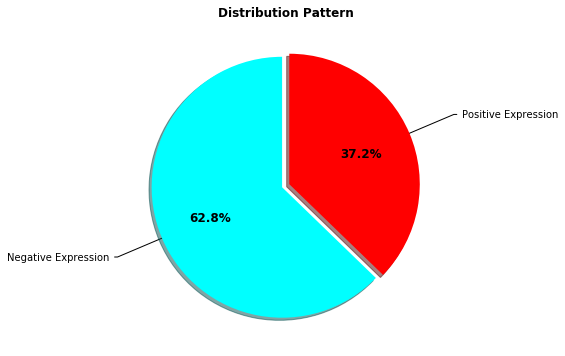

In [19]:
#let's see distribution of the predicted results
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))

pie_chart_exploded = (0.03, 0.03)
wedges, texts, autotexts = ax.pie(counts, autopct='%1.1f%%', explode=pie_chart_exploded,  shadow=True, startangle=90, 
                                  colors=colors,
                                  textprops=dict(color="black"))
labels = ["Negative Expression","Positive Expression"]

plt.setp(autotexts, size=12, weight="bold")

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)
    
ax.set_title("Distribution Pattern",size=12, weight="bold")
plt.savefig(path + 'distribution_pattern'+str(PATIENT_ID)+ '.svg',format='svg')
plt.show()

# Convert to color heatmap

In [20]:
colors = np.array(colors)
predicts = []
predicts_bin = []

for item in prediction_array:
    predicts.append(colors[np.argmax(item)] * np.max(item))
    predicts_bin.append(colors[np.argmax(item)] * 1.0)

predicts = np.array(predicts)    
predicts_bin = np.array(predicts_bin)   

True

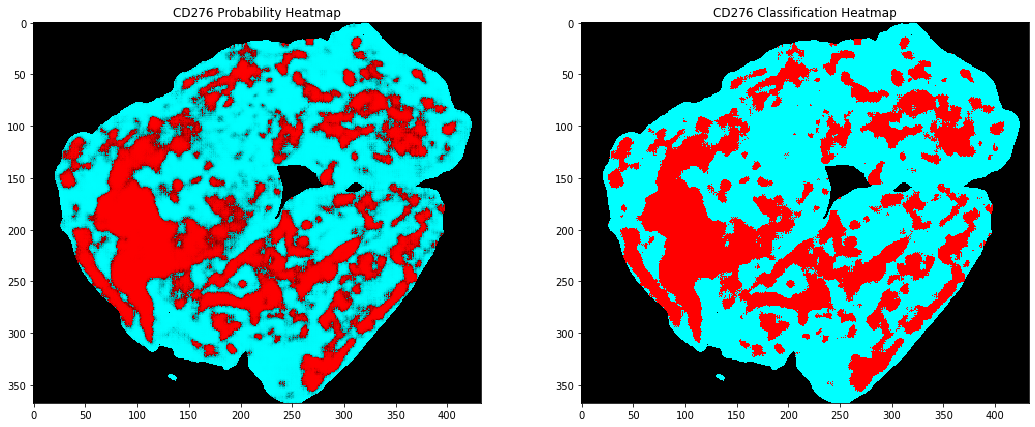

In [21]:
r_channel = predicts[:,0] 
r_channel[bk_position] = 0
g_channel = predicts[:,1] 
g_channel[bk_position] = 0
b_channel = predicts[:,2] 
b_channel[bk_position] = 0
r = r_channel.reshape(rows,cols)
g = g_channel.reshape(rows,cols)
b = b_channel.reshape(rows,cols)

heatmap = cv2.merge([r, g,b])
cv2.imwrite(path + 'brain_cd276_heatmap'+str(PATIENT_ID) +'.bmp', cv2.merge([b, g,r])*256)

r_channel = predicts_bin[:,0] 
r_channel[bk_position] = 0
g_channel = predicts_bin[:,1] 
g_channel[bk_position] = 0
b_channel = predicts_bin[:,2] 
b_channel[bk_position] = 0
r = r_channel.reshape(rows,cols)
g = g_channel.reshape(rows,cols)
b = b_channel.reshape(rows,cols)

heatmap_bin = cv2.merge([r, g,b])

fig, ax = plt.subplots(1,2, figsize=(18, 7))

ax[0].imshow(heatmap)
ax[0].title.set_text("CD276 Probability Heatmap")
ax[1].imshow(heatmap_bin)
ax[1].title.set_text("CD276 Classification Heatmap")
plt.savefig(path + 'probability_vs_classification'+str(PATIENT_ID)+ '.svg',format='svg')

plt.savefig(path + 'brain_cd276_heatmap'+str(PATIENT_ID)+ '.svg',format='svg')

cv2.imwrite(path + 'brain_cd276_heatmap_bin'+str(PATIENT_ID) +'.bmp', cv2.merge([b, g,r])*256)